# Building a basic Model for MNIST Image Classification
## Targets:
* Getting the correct set-up
* Adding basic transformers and data loaders
* Setting up basic training and testing loop

## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Add Data Transformer, Data Loaders and training and testing data

In [ ]:
#Data Transformations

# Train Phase transformations
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
# Load Train and Test Data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Configure Test/Train Dataloaders
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

100%|██████████| 9912422/9912422 [00:00<00:00, 127367981.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39612718.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34952222.44it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19659988.41it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model Defination

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model1().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14             [

##Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Start Training Loop

In [ ]:
model =  Model1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.6366216540336609 Batch_id=468 Accuracy=31.41: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]



Test set: Average loss: 0.4286, Accuracy: 8714/10000 (87.1400%)

EPOCH: 1


Loss=0.09627410024404526 Batch_id=468 Accuracy=92.55: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]



Test set: Average loss: 0.1173, Accuracy: 9657/10000 (96.5700%)

EPOCH: 2


Loss=0.04349401593208313 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0778, Accuracy: 9747/10000 (97.4700%)

EPOCH: 3


Loss=0.08607116341590881 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]



Test set: Average loss: 0.0500, Accuracy: 9859/10000 (98.5900%)

EPOCH: 4


Loss=0.11124636977910995 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]



Test set: Average loss: 0.0676, Accuracy: 9784/10000 (97.8400%)

EPOCH: 5


Loss=0.015022684819996357 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]



Test set: Average loss: 0.0391, Accuracy: 9866/10000 (98.6600%)

EPOCH: 6


Loss=0.07727105915546417 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]



Test set: Average loss: 0.0380, Accuracy: 9880/10000 (98.8000%)

EPOCH: 7


Loss=0.007323082536458969 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]



Test set: Average loss: 0.0317, Accuracy: 9897/10000 (98.9700%)

EPOCH: 8


Loss=0.09453493356704712 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]



Test set: Average loss: 0.0309, Accuracy: 9890/10000 (98.9000%)

EPOCH: 9


Loss=0.06652157753705978 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]



Test set: Average loss: 0.0310, Accuracy: 9900/10000 (99.0000%)

EPOCH: 10


Loss=0.0087586659938097 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]



Test set: Average loss: 0.0362, Accuracy: 9891/10000 (98.9100%)

EPOCH: 11


Loss=0.056458551436662674 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]



Test set: Average loss: 0.0341, Accuracy: 9891/10000 (98.9100%)

EPOCH: 12


Loss=0.09769440442323685 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]



Test set: Average loss: 0.0328, Accuracy: 9898/10000 (98.9800%)

EPOCH: 13


Loss=0.018340032547712326 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.0394, Accuracy: 9872/10000 (98.7200%)

EPOCH: 14


Loss=0.022712742909789085 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]



Test set: Average loss: 0.0292, Accuracy: 9905/10000 (99.0500%)



## Plot the graphs to analyze the model

Text(0.5, 1.0, 'Test Accuracy')

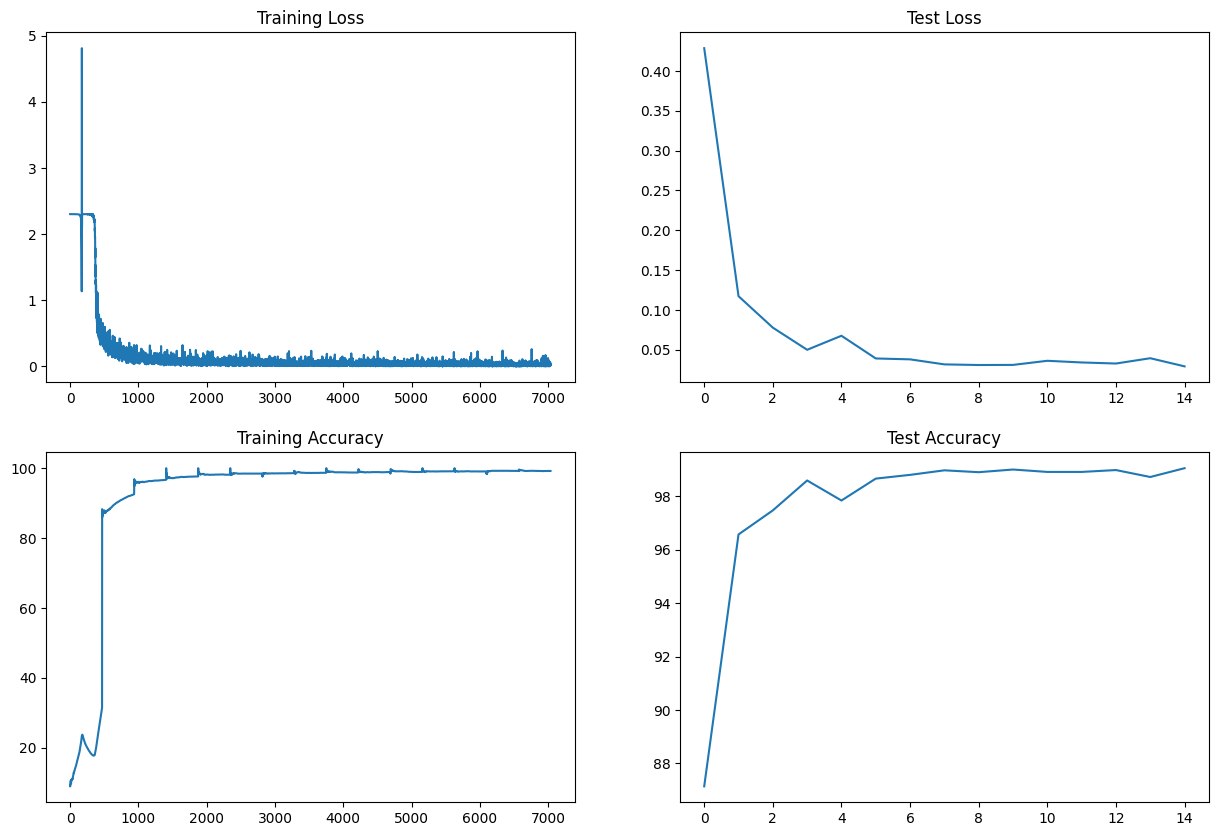

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Result
* **Total number of parameters**: 194.8 k
* **Best Training Accuracy**: 99.21 (at 15th Epoch)
* **Best Test Accuracy**: 99.05 (at 15th Epoch)

# Analysis
* **Both training and testing accuracies are very high** (more than 99%), which indicates that the model is capable of learning the patterns in the data effectively
* The training accuracy is higher than the testing accuracy --> this suggests that the model might be **overfitting the training data**
* To improve generalization, we will consider techniques like **regularization, dropout in the next model**